# 复现ROIC因子
## 计算思路
1. 合并income statement和balance sheet中所需数据
1. 先不考虑公告修正情况，用最新版公告数据计算ROIC（TTM）
2. 遍历被修改的公告，得到修改前的ROIC（TTM）
3. 合并两部分数据并向后填充
4. 导入中证800成分数据（2011年末至今），进行股票筛选
5. 用秩标准化清洗因子数据
6. 导入价格数据和行业分类数据，用alphalens包计算

## 计算方法
+ ROIC = 息前税后利润/投资资本
   + 息前税后利润 = EBIT * (1 - Effective Tax Rate)
   + Effective Tax Rate = 实缴利息/税前利润
   + 投资资本 = 归属于母公司股东净资产 + 有息负债 - 现金
   + 有息负债 = 短期借款 + 一年内到期的长期负债 + 长期借款 + 应付债券 + 长期应付款
+ 数据源：
   + income statement——tot_profit, inc_tax, ebit
   + balance sheet——tot_shrhldr_eqy_excl_min_int, st_borrow, non_cur_liab_due_within_1y, lt_borrow, bonds_payable, lt_payable, monetary_cap

In [1]:
import datetime as dt
from impala.dbapi import connect
from impala.util import as_pandas
import alphalens
import pandas as pd
import numpy as np

print (dt.datetime.today())
##连接数据库
connection = connect(host='10.0.80.11', port=10000, auth_mechanism='PLAIN', 
                     user='ircp_iquant',password='ircp_iquant@2019')  
#获取用于计算息前税后利润的数据
sql = '''SELECT wind_code,ann_dt,report_period,statement_type,tot_profit,inc_tax,ebit
FROM ods_newwind.ashareincome
WHERE statement_type IN ('408005000' , '408001000') and comp_type_code=1
ORDER BY report_period DESC
'''

cur = connection.cursor()
cur.execute(sql)
income_data = as_pandas(cur)
cur.close()
income_data.head()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


2020-07-08 10:33:10.310796


,wind_code,ann_dt,report_period,statement_type,tot_profit,inc_tax,ebit
0,688139.SH,20200429,20200331,408001000,78363687.16,9222658.31,54245441.21
1,300271.SZ,20200427,20200331,408001000,-43185479.25,-11649048.80,NaN
2,300510.SZ,20200428,20200331,408001000,-13440628.68,1824449.08,-9842136.61
3,300397.SZ,20200427,20200331,408001000,58475584.68,7943575.08,NaN
4,688580.SH,20200630,20200331,408001000,19275946.26,2334833.49,NaN


In [2]:
#获取资产负债表的数据
sql2 = '''SELECT wind_code,ann_dt,report_period,statement_type,tot_shrhldr_eqy_excl_min_int,st_borrow,
non_cur_liab_due_within_1y,lt_borrow,bonds_payable,lt_payable,monetary_cap
FROM ods_newwind.asharebalancesheet
WHERE statement_type IN ('408005000' , '408001000') and comp_type_code=1
ORDER BY report_period DESC
'''
cur = connection.cursor()
cur.execute(sql2)
blc_data = as_pandas(cur)
cur.close()
blc_data.rename(columns={'tot_shrhldr_eqy_excl_min_int':'tot_eqy','non_cur_liab_due_within_1y':'liab_1y'},inplace=True)
blc_data.head()

,wind_code,ann_dt,report_period,statement_type,tot_eqy,st_borrow,liab_1y,lt_borrow,bonds_payable,lt_payable,monetary_cap
0,688066.SH,20200428,20200331,408001000,1.168274e+09,5.989000e+07,NaN,NaN,NaN,NaN,2.881998e+08
1,600416.SH,20200430,20200331,408001000,2.569150e+09,5.328205e+09,5.389228e+08,1.090000e+08,NaN,NaN,2.195953e+09
2,601800.SH,20200429,20200331,408001000,2.300087e+11,7.784572e+10,3.131800e+10,2.515173e+11,3.428619e+10,NaN,1.307148e+11
3,002666.SZ,20200429,20200331,408001000,3.009333e+09,5.826220e+08,NaN,NaN,NaN,NaN,7.638456e+08
4,600527.SH,20200430,20200331,408001000,2.375352e+09,NaN,NaN,NaN,NaN,NaN,4.851053e+08


In [3]:
#数据合并
roic_data=pd.merge(income_data,blc_data,how='left',on=['wind_code','ann_dt','report_period','statement_type'])

In [4]:
#暂时不考虑公告修正的情况，按ann_dt排序，有重复report_period的保留最早的ann_dt
data=roic_data[roic_data['statement_type']=='408001000'].dropna(axis=0,how='all').sort_values(by='ann_dt',axis=0,ascending=True)
data=data[~data[['wind_code','report_period']].duplicated()]
data['ROIC']=np.nan
data.head()
datacopy=data.pivot(index='report_period',columns='wind_code')

In [5]:
#运行进度记录
count=0
tot=len(datacopy.index.unique())
begin=dt.datetime.today()
print('begin at',begin)
#以report_period循环
for rep_per in datacopy.index.unique():
    if not (rep_per.endswith('0331') or rep_per.endswith('0630') or rep_per.endswith('0930') or rep_per.endswith('1231')):
        continue
    #定义获取给定report_period的当期、去年年末、去年同期的数据
    def get_data(report,dataname):
        this=datacopy.loc[report][dataname].tolist()
        yearend=datacopy.loc[str(int(report[:4])-1)+'1231'][dataname].tolist()
        last=datacopy.loc[str(int(report)-10000)][dataname].tolist() if str(int(report)-10000) in datacopy.index \
            else [np.nan for _ in this]
        #若为半年报或三季报，则尝试用平均来计算去年同期的数据
        if not report.endswith('31'):
            if report.endswith('0630'):
                date1=str(int(report)-10000-299)
                date2=str(int(report)-10000+300)
            elif report.endswith('0930'):
                date1=str(int(report)-10000-300)
                date2=str(int(report)-10000+301)
            if date1 in datacopy.index and date2 in datacopy.index:
                avrg=((datacopy.loc[date1][dataname]+datacopy.loc[date2][dataname])/2).tolist()
                last=[avrg[i] if np.isnan(last[i]) else last[i] for i in range(len(last))]
        return [this,yearend,last]
    if not str(int(rep_per[:4])-1)+'1231' in datacopy.index:
            continue
    
    # 获取EBIT、所缴税、税前利润数据
    ebitdata=get_data(rep_per,'ebit')
    taxdata=get_data(rep_per,'inc_tax')
    totprofitdata=get_data(rep_per,'tot_profit')
    # NOPAT=EBIT*（1-所缴税/税前利润）
    nopatdata=list()
    for i in range(3):
        nopatdata.append(np.array(ebitdata[i])*(1-np.array(taxdata[i])/np.array(totprofitdata[i])))
    nopat=nopatdata[0]+nopatdata[1]-nopatdata[2]
    #获取归属母公司股东净资产、现金数据，并用TTM算法计算
    eqydata=get_data(rep_per,'tot_eqy')
    eqy=(np.array(eqydata[0])+np.array(eqydata[2]))/2
    cashdata=get_data(rep_per,'monetary_cap')
    cash=(np.array(cashdata[0])+np.array(cashdata[2]))/2
    
    #获取短期借款、一年内到期的非流动负债、长期借款、应付债券、长期应付账款数据
    def liabsum(data):
        data1=np.array(data[0])
        data1[np.isnan(data1)]=0
        data2=np.array(data[2])
        data2[np.isnan(data2)]=0
        return (data1+data2)/2    
    stbr=liabsum(get_data(rep_per,'st_borrow'))
    liab1y=liabsum(get_data(rep_per,'liab_1y'))
    ltbr=liabsum(get_data(rep_per,'lt_borrow'))
    bdpay=liabsum(get_data(rep_per,'bonds_payable'))
    ltpay=liabsum(get_data(rep_per,'lt_payable'))
    liab=stbr+liab1y+ltbr+bdpay+ltpay
    #数据记录
    datacopy.loc[rep_per,'ROIC']=nopat/(eqy+liab-cash)
    count+=1
    print('百分比:',count/tot*100,'%','time used:',dt.datetime.today()-begin)
print('finish at',dt.datetime.today(),'total time used:',dt.datetime.today()-begin)

begin at 2020-07-08 10:34:15.953577
百分比: 0.7692307692307693 % time used: 0:00:06.737850
百分比: 1.5384615384615385 % time used: 0:00:12.739654
百分比: 2.307692307692308 % time used: 0:00:19.211007
百分比: 3.076923076923077 % time used: 0:00:25.256106
百分比: 3.8461538461538463 % time used: 0:00:31.376500
百分比: 4.615384615384616 % time used: 0:00:37.406339
百分比: 5.384615384615385 % time used: 0:00:43.663415
百分比: 6.153846153846154 % time used: 0:00:49.829173
百分比: 6.923076923076923 % time used: 0:00:56.080755
百分比: 7.6923076923076925 % time used: 0:01:03.807328
百分比: 8.461538461538462 % time used: 0:01:10.589685
百分比: 9.230769230769232 % time used: 0:01:16.829383
百分比: 10.0 % time used: 0:01:23.714899
百分比: 10.76923076923077 % time used: 0:01:30.300958
百分比: 11.538461538461538 % time used: 0:01:37.442874
百分比: 12.307692307692308 % time used: 0:01:44.332536
百分比: 13.076923076923078 % time used: 0:01:50.925564
百分比: 13.846153846153847 % time used: 0:01:57.029022
百分比: 14.615384615384617 % time used: 0:02:03.184922

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


百分比: 59.23076923076923 % time used: 0:08:21.840361
百分比: 60.0 % time used: 0:08:28.672048
百分比: 60.76923076923077 % time used: 0:08:35.436673
百分比: 61.53846153846154 % time used: 0:08:41.482168
百分比: 62.30769230769231 % time used: 0:08:47.637658
百分比: 63.07692307692307 % time used: 0:08:55.028121
百分比: 63.84615384615384 % time used: 0:09:02.213056
百分比: 64.61538461538461 % time used: 0:09:08.359789
百分比: 65.38461538461539 % time used: 0:09:15.121731
百分比: 66.15384615384615 % time used: 0:09:22.667877
百分比: 66.92307692307692 % time used: 0:09:29.617254
百分比: 67.6923076923077 % time used: 0:09:36.243075
百分比: 68.46153846153847 % time used: 0:09:43.394519
百分比: 69.23076923076923 % time used: 0:09:50.726636
百分比: 70.0 % time used: 0:09:57.726315
百分比: 70.76923076923077 % time used: 0:10:03.826060
百分比: 71.53846153846153 % time used: 0:10:09.940805
百分比: 72.3076923076923 % time used: 0:10:16.921093
百分比: 73.07692307692307 % time used: 0:10:24.605342
百分比: 73.84615384615385 % time used: 0:10:31.167493
百分比: 74.

In [6]:
#计算有公告修正的数据。按report_period排序，对每个ann_dt若有多期报告，则取最新一期
moddata=roic_data[roic_data['statement_type']=='408005000'].sort_values(by='report_period',axis=0,ascending=False) \
    .dropna(axis=0,how='all')
moddata=moddata[~moddata[['wind_code','ann_dt']].duplicated()]
moddata['ROIC']=np.nan
#运行进度记录
count=0
tot=len(moddata)
begin=dt.datetime.today()
print('begin at',begin)
def mod_roic(code,rep,ann):
    temp_data=roic_data[(roic_data['wind_code']==code) & (roic_data['ann_dt']<=ann)]
    if (rep<temp_data['report_period'].max(axis=0)) or \
        (len(temp_data[(temp_data['report_period']==rep) & (temp_data['ann_dt']==ann)])>1):
        return np.nan
    #定义找出当期、去年年末、去年同期的数据
    def mod_data(report,dataname):
        #当期、去年年末的数据
        try:
            this=temp_data[temp_data['report_period']==report][dataname].tolist()[0]
        except IndexError: #部分20191231期数据不完善，特此处理并检验
            print(report,'\n',dataname,'\n',temp_data[temp_data['report_period']==report])
            return np.nan
        yearend=temp_data[temp_data['report_period']==str(int(report[:4])-1)+'1231'][dataname].tolist()[0] \
            if len(temp_data[temp_data['report_period']==str(int(report[:4])-1)+'1231'][dataname]) else np.nan
        #去年同期的数据：若为一月或十二月的，则无法通过上下期平均计算。
        if report.endswith('31'):
            last=temp_data[temp_data['report_period']==str(int(report)-10000)][dataname].tolist()[0] \
                if len(temp_data[temp_data['report_period']==str(int(report)-10000)][dataname]) else np.nan
        else:
            if report.endswith('0630'):
                date1=str(int(report)-10000-299)
                date2=str(int(report)-10000+300)
            elif report.endswith('0930'):
                date1=str(int(report)-10000-300)
                date2=str(int(report)-10000+301)
            avrg=(temp_data[temp_data['report_period']==date1][dataname].tolist()[0]+ \
                  temp_data[temp_data['report_period']==date2][dataname].tolist()[0])/2.0 \
                if len(temp_data[temp_data['report_period']==date1][dataname]) & len(temp_data[temp_data['report_period']==date2][dataname]) \
                else np.nan
            last=temp_data[temp_data['report_period']==str(int(report)-10000)][dataname].tolist()[0] \
                if len(temp_data[temp_data['report_period']==str(int(report)-10000)][dataname]) else avrg
        return [this,yearend,last]
    # 获取EBIT、所缴税、税前利润数据
    ebitdata=mod_data(rep,'ebit')
    taxdata=mod_data(rep,'inc_tax')
    totprofitdata=mod_data(rep,'tot_profit')
    #print(ebitdata,taxdata,totprofitdata)
    # NOPAT=EBIT*（1-所缴税/税前利润）
    nopatdata=list()
    for i in range(3):
        nopatdata.append(ebitdata[i]*(1-taxdata[i]/totprofitdata[i]))
    if np.isnan(nopatdata).any():
        return np.nan
    nopat=nopatdata[0]+nopatdata[1]-nopatdata[2]
    #获取归属母公司股东净资产、现金数据，并用TTM算法计算
    eqydata=mod_data(rep_per,'tot_eqy')
    cashdata=mod_data(rep_per,'monetary_cap')
    if (np.isnan(eqydata).any()) or (np.isnan(cashdata).any()):
        return np.nan
    eqy=(eqydata[0]+eqydata[2])/2
    cash=(cashdata[0]+cashdata[2])/2
    
    #获取短期借款、一年内到期的非流动负债、长期借款、应付债券、长期应付账款数据
    def liabsum(data):
        for i in range(3):
            data[i]=0 if np.isnan(data[i]) else data[i]
        return (data[0]+data[2])/2
    stbr=liabsum(get_data(rep_per,'st_borrow'))
    liab1y=liabsum(get_data(rep_per,'liab_1y'))
    ltbr=liabsum(get_data(rep_per,'lt_borrow'))
    bdpay=liabsum(get_data(rep_per,'bonds_payable'))
    ltpay=liabsum(get_data(rep_per,'lt_payable'))
    liab=stbr+liab1y+ltbr+bdpay+ltpay    
    #数据记录
    return nopat/(eqy+liab-cash)
for it in moddata.index:
    rep=moddata.loc[it]['report_period']
    if not (rep.endswith('0331') or rep.endswith('0630') or rep.endswith('0930') or rep.endswith('1231')):
        continue
    moddata.loc[it,'ROIC']=mod_roic(moddata.loc[it]['wind_code'],moddata.loc[it]['report_period'],moddata.loc[it]['ann_dt'])
    count+=1
    if count%150==0:
        print('百分比:',count/tot*100,'%','time used:',dt.datetime.today()-begin)
print('finish at',dt.datetime.today(),'total time used:',dt.datetime.today()-begin)
moddata=moddata[['wind_code','ann_dt','ROIC','report_period']].dropna(how='any',axis=0) 

begin at 2020-07-08 10:46:41.840451
百分比: 4.897159647404505 % time used: 0:00:04.111561
百分比: 9.79431929480901 % time used: 0:00:08.712830
百分比: 14.691478942213514 % time used: 0:00:13.249904
百分比: 19.58863858961802 % time used: 0:00:17.827480
百分比: 24.48579823702253 % time used: 0:00:22.182451
百分比: 29.38295788442703 % time used: 0:00:26.362394
百分比: 34.280117531831536 % time used: 0:00:30.624630
百分比: 39.17727717923604 % time used: 0:00:34.688267
百分比: 44.07443682664055 % time used: 0:00:38.941205
百分比: 48.97159647404506 % time used: 0:00:42.979232
百分比: 53.86875612144956 % time used: 0:00:47.026826
百分比: 58.76591576885406 % time used: 0:00:50.967954
百分比: 63.66307541625857 % time used: 0:00:55.395880
百分比: 68.56023506366307 % time used: 0:00:59.480703
百分比: 73.45739471106758 % time used: 0:01:03.752741
百分比: 78.35455435847209 % time used: 0:01:07.811380
百分比: 83.2517140058766 % time used: 0:01:11.712255
百分比: 88.1488736532811 % time used: 0:01:15.848335
百分比: 93.04603330068561 % time used: 0:01:19.750

In [7]:
#按report_period排序，对每个ann_dt若有多期报告，则取最新一期
roicdf=datacopy.stack().reset_index()
roicdf=roicdf[['wind_code','ann_dt','ROIC','report_period']].dropna(axis=0,how='any')
#无修正数据与有修正数据合并
roicdf=pd.concat([roicdf,moddata]).sort_values(by='report_period',axis=0,ascending=False)
roicdf=roicdf[~roicdf[['wind_code','ann_dt']].duplicated()].sort_values(by='ann_dt')
#筛选需要的数据
roicdf=roicdf[['wind_code','ann_dt','ROIC']].dropna(axis=0,how='any')
#定义'20001212'转化为'2000-12-12'型函数
def stddate(string):
    return string[:4]+'-'+string[4:6]+'-'+string[6:]
#转化日期为填充做准备
roicdf['ann_dt']=roicdf['ann_dt'].apply(stddate)
begindate=roicdf['ann_dt'].min(axis=0)
enddate=roicdf['ann_dt'].max(axis=0)
print('Dates range from',begindate,'to',enddate)
roicdf=roicdf.pivot(index='ann_dt',columns='wind_code')
#print(roicdf)

Dates range from 1991-07-29 to 2020-07-07


In [8]:
#定义获取前十个字符的函数
timezone = "America/New_York" 
def str10(string):
    return str(string)[:10]
result=roicdf.reindex(pd.Series(pd.date_range(begindate,enddate,freq='B'),name='date').apply(str10)).ffill()
result=result.stack().reset_index()
print(result.head())

         date  wind_code      ROIC
0  1991-07-29  600601.SH  0.088909
1  1991-07-29  600651.SH  0.373271
2  1991-07-29  600652.SH  0.799506
3  1991-07-29  600653.SH  0.117060
4  1991-07-29  600655.SH  0.838621


In [15]:
result[result['date']>='2008-12-31'].to_csv('投资资本回报率因子.csv')

In [9]:
#获取中证800成分股数据
index_data=pd.read_csv('index_data.csv')
csi800=index_data[['trade_dt','s_con_windcode']].sort_values(by='trade_dt')
csi800['trade_dt']=csi800['trade_dt'].apply(str)
csi800['trade_dt']=csi800['trade_dt'].apply(stddate)
csi800=csi800.set_index('trade_dt')
print((csi800.index).unique())

Index(['2011-07-06', '2011-09-05', '2011-09-06', '2011-12-22', '2011-12-23',
       '2011-12-26', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30',
       ...
       '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-30',
       '2019-12-31', '2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07'],
      dtype='object', name='trade_dt', length=1959)


In [10]:
#筛选成分股数据并进行因子清洗
stdrs=result.dropna(axis=0,how='any').sort_values(by='date')
stdrs=stdrs[(stdrs['date']>='2011-12-22') & (stdrs['date'].isin(csi800.index))]
def csi(data):
    return data['wind_code'].isin(csi800.loc[data.name]['s_con_windcode'].tolist())
def stdize(data):
    data=data.rank()
    data=(data-np.mean(data))/np.std(data)
    return data
stdrs=stdrs[stdrs.groupby('date').apply(csi).tolist()]
stdrs['ROIC']=stdrs.groupby('date')['ROIC'].apply(stdize)
stdrs['date']=[pd.Timestamp(i).tz_localize(timezone) for i in stdrs['date']]
stdrs=stdrs.set_index(['date','wind_code'])

In [11]:
#导入价格数据并处理时区问题
price_data=pd.read_csv('price_data.csv')
price_data['trade_dt']=price_data['trade_dt'].apply(str)
prices=price_data[price_data['trade_dt']>='20111222']
prices['trade_dt']=prices['trade_dt'].apply(stddate)
prices.columns=['Code','Date','Close']
prices=prices.pivot(index='Date',columns='Code')
prices=prices['Close']
prices.index = [pd.Timestamp(i).tz_localize(timezone) for i in prices.index]

KeyError: 'trade_dt'

In [ ]:
#导入行业数据并处理时区问题
groups=pd.read_csv('industry.csv',index_col=0)
clas=groups
clas.index=[pd.Timestamp(i).tz_localize(timezone) for i in clas.index]
clas=clas.stack()

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.729812,-1.030605,-1.384887,0.200438,295334,20.042047
2,-1.038783,-0.338782,-0.691761,0.199681,294261,19.969231
3,-0.346873,0.349589,0.000108,0.199785,294447,19.981854
4,0.342356,1.039685,0.692011,0.199697,294261,19.969231
5,1.035172,1.729812,1.384998,0.200388,295269,20.037636


Returns Analysis


,20D
Ann. alpha,-0.014
beta,-0.081
Mean Period Wise Return Top Quantile (bps),-10.039
Mean Period Wise Return Bottom Quantile (bps),20.591
Mean Period Wise Spread (bps),-30.630


/usr/lib/python3/dist-packages/pandas/core/indexes/datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

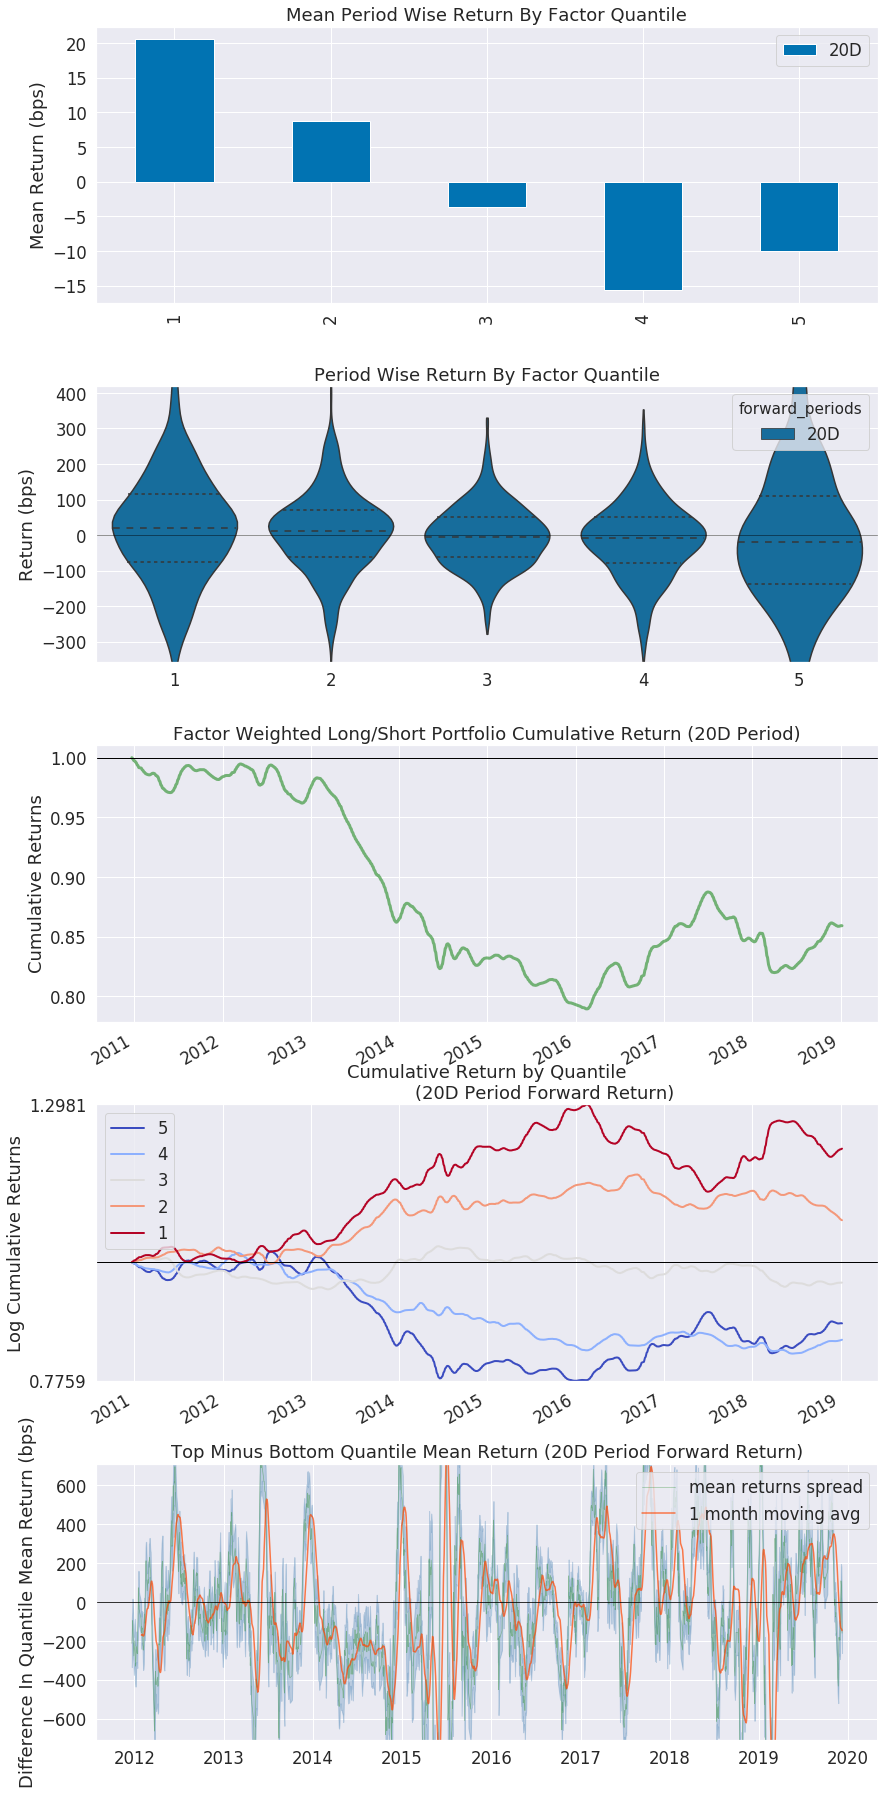

Information Analysis


,20D
IC Mean,0.012
IC Std.,0.126
Risk-Adjusted IC,0.096
t-stat(IC),4.225
p-value(IC),0.000
IC Skew,0.186
IC Kurtosis,-0.188


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


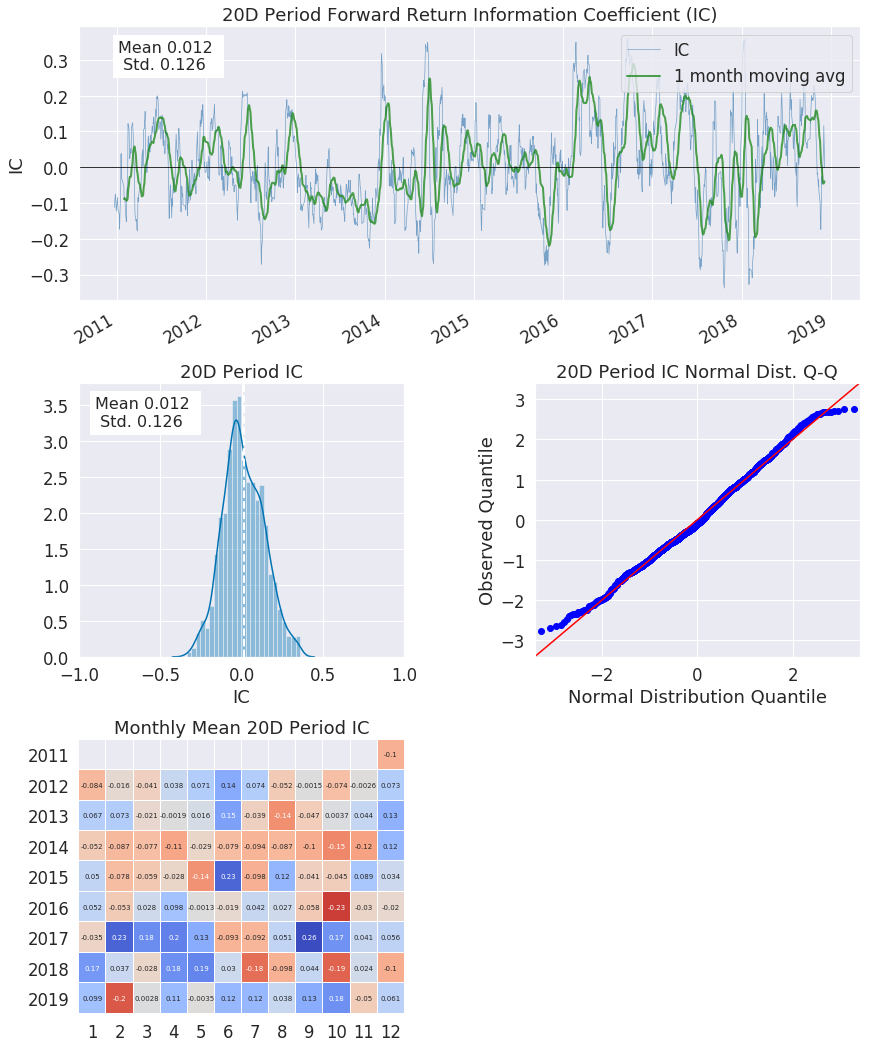

Turnover Analysis


,20D
Quantile 1 Mean Turnover,0.064
Quantile 2 Mean Turnover,0.103
Quantile 3 Mean Turnover,0.113
Quantile 4 Mean Turnover,0.099
Quantile 5 Mean Turnover,0.054


,20D
Mean Factor Rank Autocorrelation,0.98


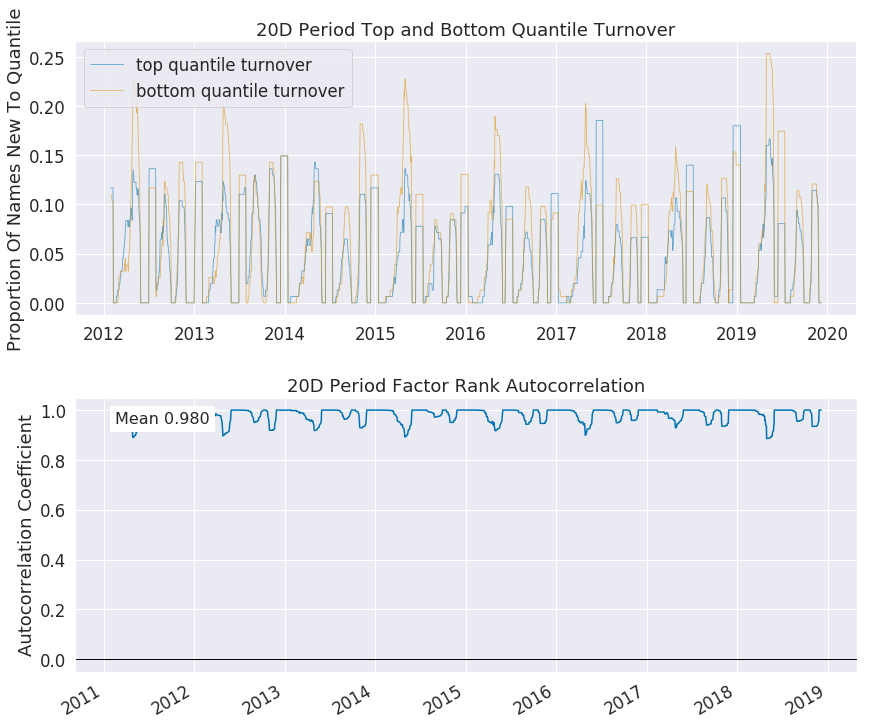

In [14]:
#使用alphalens进行因子检验
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(stdrs,prices,groupby=clas,periods=(20,),quantiles=5)
alphalens.tears.create_full_tear_sheet(factor_data)